# Trabalho Prático 2 - Implementação do Algoritmo de Boosting

Para executar, por favor mantenha o arquivo "tic-tac-toe.data" na mesma pasta que esse Notebook.

## Importando bibliotecas e preparando os dados

Embora a implementação do algoritmo de AdaBoost deve ser feito sem o uso de bibliotecas, foi liberado o uso de DecisionTreeClassifier do SciKit com profundidade 1 para os Stumps do AdaBoost.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier

In [ ]:
df = pd.read_csv('tic-tac-toe.data', header=None)
df = df.rename(columns={0:'top-left-square',
                        1: 'top-middle-square',
                        2: 'top-right-square',
                        3: 'middle-left-square',
                        4: 'middle-middle-square',
                        5: 'middle-right-square',
                        6: 'bottom-left-square',
                        7: 'bottom-middle-square',
                        8: 'bottom-right-square',
                        9: 'class'})
df.head()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


Como o algoritmo DecisionTreeClassifier não aceita atributos categóricos, precisou-se usar OneHotEncoding para que os Stumps conseguissem fazer uma classificação. Isso é feito para X abaixo com a função get_dummies da biblioteca Pandas. Nesse caso, cada coluna é expandida em 3, que são os valores possíveis de cada uma. Então, o valor da coluna em uma linha é 0 se não correspondia a esse valor, e 1 se correspondia.

In [ ]:
df_X = pd.get_dummies(df[df.columns[:-1]])
df_X.head()

,top-left-square_b,top-left-square_o,top-left-square_x,top-middle-square_b,top-middle-square_o,top-middle-square_x,top-right-square_b,top-right-square_o,top-right-square_x,middle-left-square_b,...,middle-right-square_x,bottom-left-square_b,bottom-left-square_o,bottom-left-square_x,bottom-middle-square_b,bottom-middle-square_o,bottom-middle-square_x,bottom-right-square_b,bottom-right-square_o,bottom-right-square_x
0,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,1,0
1,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
3,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,1,0,0,1,0,0
4,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0


Já para y, codificou-se o valor 'positive' como 1 e 'negative' como -1. Inicialmente, não se dividiu em dados de teste e treino, pois isso será feito na função de 5-fold Cross-Validation.

In [ ]:
X = df_X.values

y = []
for label in df.iloc[:,-1].values:
    if label == 'positive':
        y.append(1)
    elif label == 'negative':
        y.append(-1)

y = np.array(y)

## Implementação do AdaBoost

Implementou-se o algoritmo como uma classe cujo único parâmetro necessário é o número de Decision Stumps a serem utilizados. Como é criado um Stump a cada iteração, a quantidade de Stumps é igual ao número de iterações que o algoritmo irá rodar. Dentro da classe tem as funções para atualizar α e w de acordo com as funções:

$$ α^t = 0.5 \log{\frac{1-erro^t}{erro^t}} $$
$$ w_i^{t+1} = \frac{w_i^t}{z} e^{-α^t * y_pred^t * y}  $$

onde t representa que o valor é da iteração atual e o fator de normalização z escolhido, o qual deve garantir que a soma de todos os $w_i^{t+1}$ seja igual a 1, foi a própria soma de todos os $w_i^{t+1}$, já que um número dividido por ele mesmo será sempre 1.

A cada chamada de fit, são resetados os vetores dos valores α, w e o vetor em que ficam guardados os Stumps. Em cada iteração, gera-se um novo Decision Stump, treina-o com os dados recebidos, faz-se a predição e calcula-se o erro ponderado de acordo com os pesos de cada exemplo, o vetor w. Então atualiza-se os valores de α e w para a próxima iteração.

A função predict recebe os dados de treino e o coloca em uma classe, 1 ou -1, a partir dos stumps e dos seus pesos α. Por fim, esses dados são divididos em 5 folds na função cross-validation, cada um sendo passado como teste uma vez quando os outros são utilizados como treino. Essa função retorna a taxa de erro simples de cada fold, isto é, a proporção do teste que o algoritmo errou.

Após a implementação completa do algoritmo, é impresso na tela um exemplo das taxas de erro simples para cada fold e a média dos 5, para um algoritmo de AdaBoost com 100 Stumps/iterações. As análises gráficas vêm na próxima seção.

In [ ]:
class AdaBoost:
    def __init__(self, num_stumps):
        self.alphas = []
        self.w = []

        self.num_stumps = num_stumps
        self.stumps = []

    def atualiza_alpha(self, erro):
        self.alphas.append(0.5 * np.log((1-erro)/erro))

    def atualiza_w(self, alpha, y, y_pred):
        self.w = self.w * np.exp(-alpha * y_pred * y)
        self.w /= np.sum(self.w)

    def fit(self, X, y):
        self.alphas = []
        self.w = np.ones(len(y))/len(y)
        self.stumps = []

        for _ in range(self.num_stumps):
            self.stumps.append(DecisionTreeClassifier(max_depth = 1))
            self.stumps[-1].fit(X, y, sample_weight = self.w)
            y_pred = self.stumps[-1].predict(X)

            erro = np.sum(self.w[y_pred != y])

            self.atualiza_alpha(erro)
            self.atualiza_w(self.alphas[-1], y, y_pred)

    def predict(self, X):
        scores = np.zeros(len(X))
        for i in range(self.num_stumps):
            scores += self.alphas[i] * self.stumps[i].predict(X)

        return np.sign(scores)

    def cross_validation(self, X, y, k=5):
        tam_fold = int(len(X) / k)
        erros = []

        for i in range(k):
            X_train = np.concatenate((X[:i*tam_fold], X[(i + 1)*tam_fold:]), axis=0)
            y_train = np.concatenate((y[:i*tam_fold], y[(i + 1)*tam_fold:]), axis=0)

            X_test = X[i*tam_fold:(i + 1)*tam_fold]
            y_test = y[i*tam_fold:(i + 1)*tam_fold]

            self.fit(X_train, y_train)
            y_pred = self.predict(X_test)

            taxa_erro = np.sum(y_pred != y_test) / tam_fold
            erros.append(taxa_erro)

        return erros

clf = AdaBoost(100)
erros, erros_iter = clf.cross_validation(X, y)

for i, erro in enumerate(erros):
    print(f"Fold {i+1} - Taxa de erro: {erro}")

print()
print(f'Taxa de erro média: {np.mean(erros)}')

Fold 1 - Taxa de erro: 0.4816753926701571
Fold 2 - Taxa de erro: 0.18324607329842932
Fold 3 - Taxa de erro: 0.08376963350785341
Fold 4 - Taxa de erro: 0.6020942408376964
Fold 5 - Taxa de erro: 0.9267015706806283

Taxa de erro média: 0.4554973821989529


## Plots e análises

O primeiro plot feito foram as taxas de erros de cada fold com a mudança do número de iterações. Percebe-se que, em geral, algoritmos com mais Stumps tiveram taxas de erro sempre abaixo em todos os folds, com poucos pontos em que mais de um tamanho coincidia na taxa de erro.

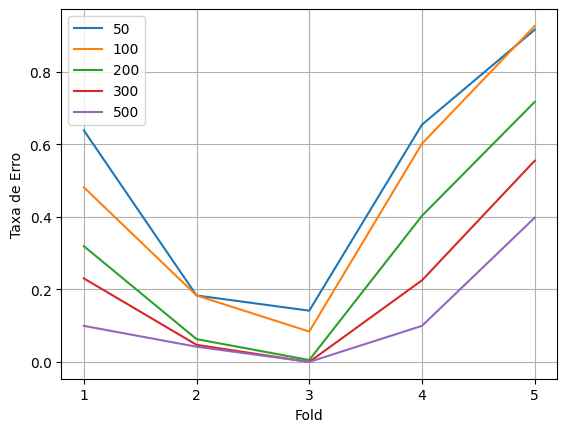

In [ ]:
tamanhos = [50, 100, 200, 300, 500]
medias = []
for n_stumps in tamanhos:
    clf = AdaBoost(n_stumps)
    erros, erros_iter = clf.cross_validation(X, y)
    medias.append(np.mean(erros))

    plt.plot([str(i) for i in range(1,6)], erros, label=n_stumps)

plt.legend()
plt.xlabel('Fold')
plt.ylabel('Taxa de Erro')
plt.grid()

Para verificar melhor a diferença na eficiência dos algoritmos de acordo com a quantidade de Stumps, plotou-se também a média dos erros dos 5 folds de acordo com o número de iterações. Novamente, percebe-se uma grande diferença a medida que o valor cresce, caindo de 50% a cerca de 12.5% entre 50 e 500 iterações. A maior queda observada, contudo, foi entre 100 e 200, caindo aproximadamente 15%.

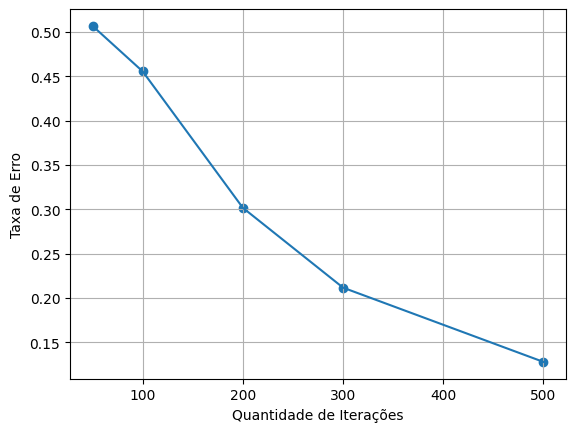

In [ ]:
plt.plot(tamanhos, medias)
plt.scatter(tamanhos, medias)
plt.xlabel('Quantidade de Iterações')
plt.ylabel('Taxa de Erro')
plt.grid()

Para observar como a escolha dos folds pode afetar os valores encontrados para medir a eficácia. Tomou-se novamente as medidas abaixo, contudo aleatorizando os dados antes de chamar a função cross_validation, que divide o folds. Foi tomada a média dos valores de cada fold e também a média de suas médias para 10 execuções, todas com os dados re-aleatorizados.

Os dois gráficos foram re-plotados abaixo, e obteve-se grande diferença de valores nos dois. Enquanto as médias de cada fold caíram de um intervalo de cerca de 90% e 0% para um intervalo de um pouco mais de 25% e aproximadamente 2.5%, o gráfico das médias das taxas dos folds teve seu máximo diminuído de um pouco mais de 50% para cerca 22% e seu mínimo de 12.5% para um valor próximo de 2.5%. Isso mostra como a distribuição dos dados nos folds pode alterar as medidas de eficácia do modelo.

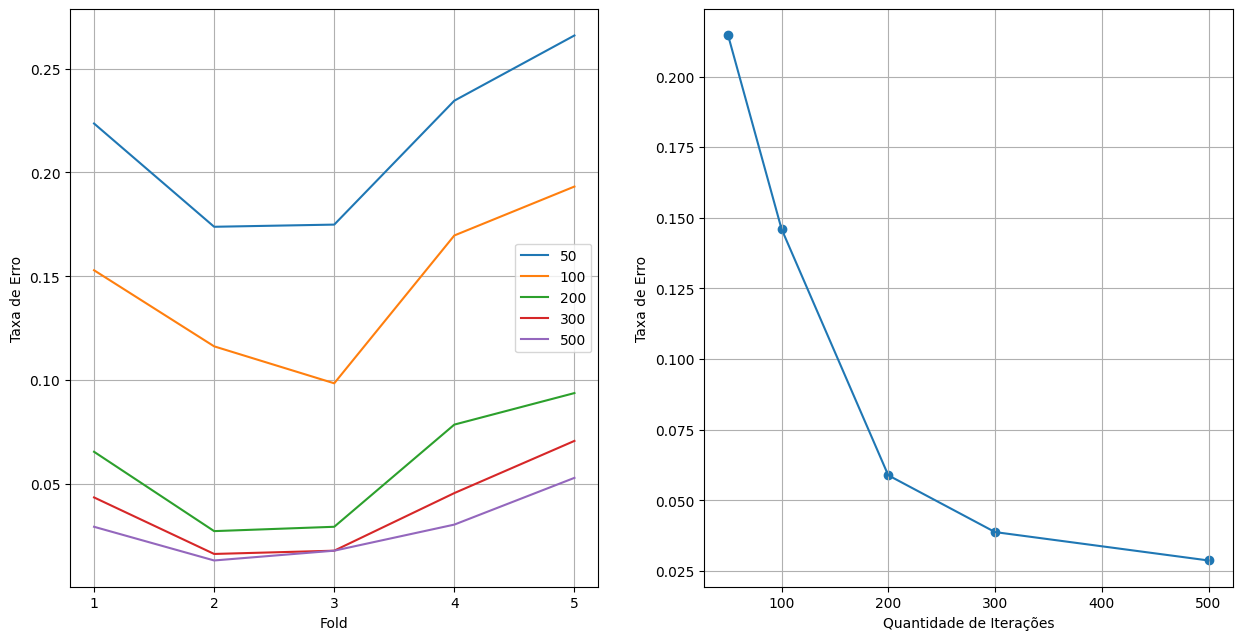

In [ ]:
medias = np.zeros(len(tamanhos))
medias_fold = np.zeros((len(tamanhos), 5))

for _ in range(10):
    for i in range(len(tamanhos)):
        clf = AdaBoost(tamanhos[i])
        erros, _ = clf.cross_validation(X, y)
        medias_fold[i] += erros
        medias[i] += np.mean(erros)

    df = df.sample(frac = 1)

    df_X = pd.get_dummies(df[df.columns[:-1]])
    X = df_X.values

    y = []
    for label in df.iloc[:,-1].values:
        if label == 'positive':
            y.append(1)
        elif label == 'negative':
            y.append(-1)
    y = np.array(y)

medias /= 10
medias_fold /= 10

fig, axs = plt.subplots(1, 2, figsize=(15,7.5))

for i in range(len(medias_fold)):
    axs[0].plot([str(i) for i in range(1,6)], medias_fold[i], label=tamanhos[i])
axs[0].set_xlabel('Fold')
axs[0].set_ylabel('Taxa de Erro')
axs[0].legend()
axs[0].grid()

axs[1].plot(tamanhos, medias)
axs[1].scatter(tamanhos, medias)
axs[1].set_xlabel('Quantidade de Iterações')
axs[1].set_ylabel('Taxa de Erro')
axs[1].grid()